# Tests on Bandit with Non-Stationary Context Distribution
Here we will test the library [IS_non_stationary_RL](https://github.com/pierresdr/IS_non_stationary_RL) to evaluate and optimize the Non-Stationary Contextual Bandit.
The in the library is defined the custom environment with a non-stationary context distribution. The environment behaviour is explained at the beginning of [NS_contextual bandits.ipynb](./non-stat_contextual_bandits.ipynb), which contains different tests of similar environments.

In [7]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Import 'IS_Non-Stationary_RL' library
import sys
sys.path.insert(1, '../../IS_non_stationary_RL/')

from policy.hyper_policy import Hyperpolicy
from policy.policy import Policy
from env.contextual_bandits import ContextualBandit
from importance_sampling.mis_balance_heuristic import MIS_bh_grad, MIS_bh_estimation, MIS_bh_estimation_range, MIS_bh_variance, objective_estimate
from run_env import play, replay
from optimize import optimize_avg_grad
from plots import plots
                        
### Import funtion that "does everything"
from optimize import intertwine_run_optimize, run_then_optimize
    
from tqdm import tqdm
import argparse, logging
import numpy as np
import matplotlib.pyplot as plt
import scipy


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Test MIS estimator with BH

In [ ]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = t
replicas = 10
all_IS_weights = np.zeros((replicas, alpha))

# Initialize hyperpolicy and env
nu = Hyperpolicy(Policy, sigma_theta=1, A=3, psi=0, phi=0.1) 
env = ContextualBandit(mean_reward=True, sigma_x=1, A=3, psi=0, phi=0.1) 

for i in tqdm(range(replicas)):    
    
    env.reset()
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
    
    # Evaluate the performance 
    all_IS_weights[i] = MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[0]

## MIS as a function of A - *OLD ENVIRONMENT*

In [181]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_A = np.linspace(1,5,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 15
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for A in tqdm(range_A):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=1, A=A, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=2, A=A, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


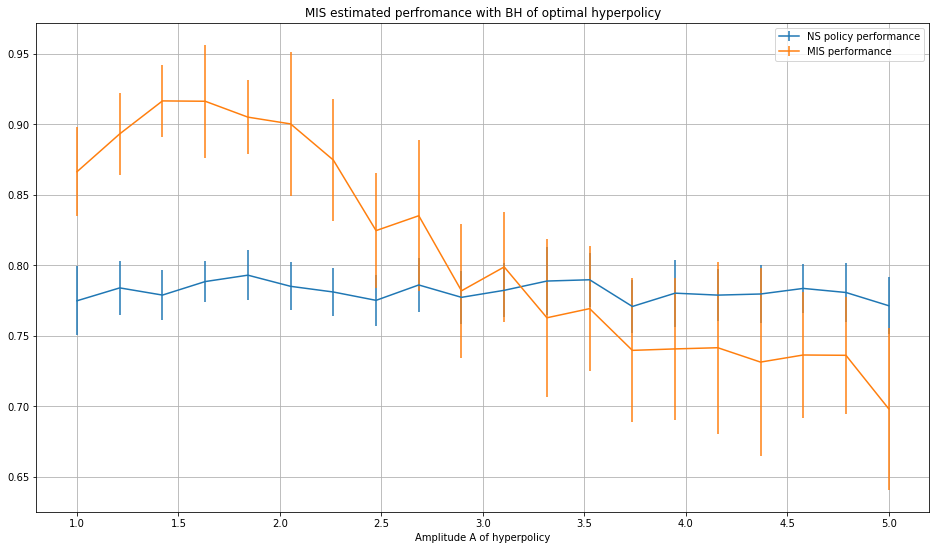

In [184]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_A, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_A, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_A, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Amplitude A of hyperpolicy')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()

## MIS as a function of sigma theta

In [185]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_sigma = np.linspace(0.1,4,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(range_sigma):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=sigma, A=5, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=2, A=5, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


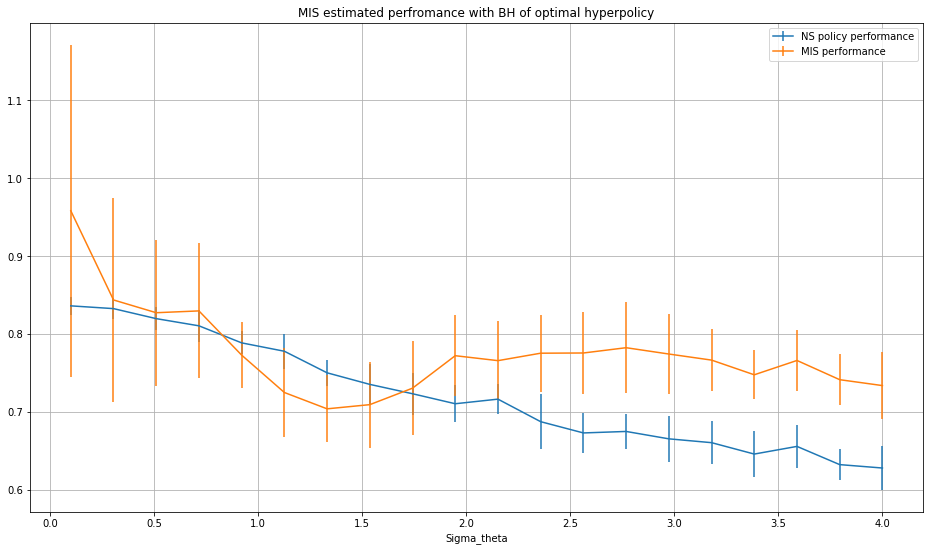

In [186]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_sigma, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_sigma, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_sigma, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Sigma_theta')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()

# Test new environment
we have two different non-stationary process (one for the context mean and one for the reward term). Combining them we can obtain any version of Non-stationary contextual bandits environment:
 - $\mu_x = \mu_r$ is the first approach with Non-Stat context distibution
 - $\mu_x=0$ is the second approach with Non-Stat reward function
 - $\mu_x=0$ and $\sigma_x=0$ Context is always equal to zero, thus it is removed 

In [22]:
hyperpolicy_param = {
    'A_theta': 3,
    'B_theta': 0,
    'phi_theta': 0.2,
    'psi_theta': 0,
    'sigma_theta': 0.1,
}

# Define environment parameters (start with no context)
args = {
    'sigma_x': 0, 
    'A_x': 0, 
    'psi_x': 0, 
    'phi_x': 0, 
    
    'A_r': 1, 
    'psi_r': 0, 
    'phi_r': 0.2,
    
    'mean_reward': True,
}

args = {
    'n_steps': 200, 
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'A_x': 0, 
    'A_theta': 3, 
    'A_r': 1, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0, 
    'phi_theta': 0.2,
    'phi_r': 0.2,
    
    'mean_reward': True,
}

out = play(**args)
nu = out[-2]
names = ['A','B']
step = [1,2]

for i,par in enumerate(names):
    new_value = getattr(nu,par) + step[i]
    setattr(nu, par, new_value)
[nu.A, nu.B]

[4, 2]

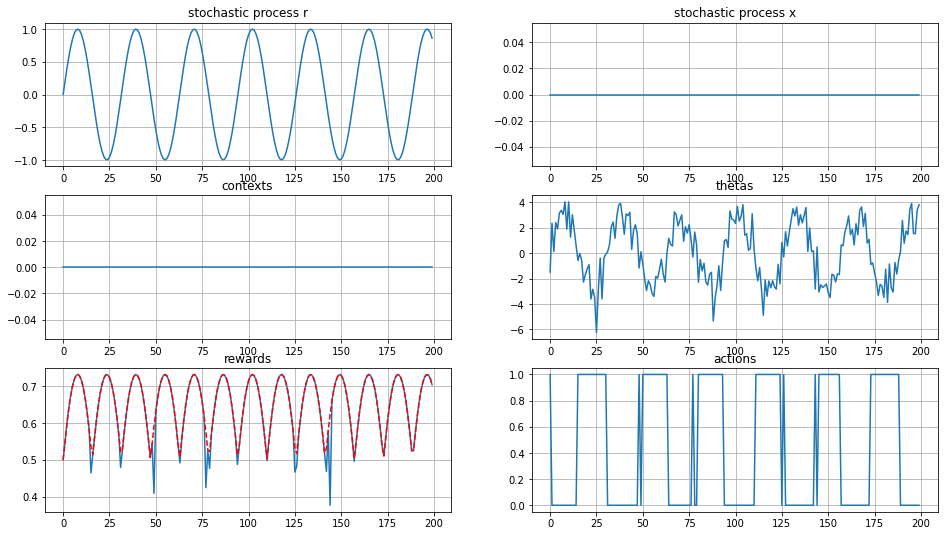

In [94]:
r_sigmoid = sigmoid(non_stat_process_x - non_stat_process_r)
r_sigmoid = np.maximum(r_sigmoid, 1-r_sigmoid)

plots = {
    'stochastic process r': [non_stat_process_r],
    'stochastic process x': [non_stat_process_x],
    'contexts': [contexts],
    'thetas': [thetas],
    'rewards': [rewards, {'x':  r_sigmoid,
                             'c': 'r',
                             'linestyle': '--'
                            }],
    'actions': [actions]
}

fig, ax = plt.subplots(int(np.ceil(len(plots)/2)),2,figsize=(16,9))



for i, (key, value) in enumerate(plots.items()):
    for v in value:
        if isinstance(v, dict):
            x = v['x']
            del v['x']
            ax[i//2,i%2].plot(x,**v)
        else:
            ax[i//2,i%2].plot(v)
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set_title(key)


plt.show()

## Evaluate randomness of rewards

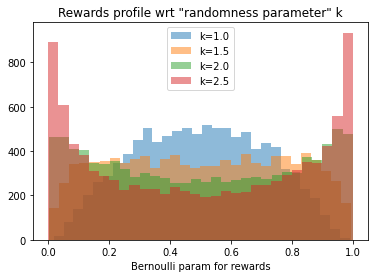

In [17]:
env = ContextualBandit(mean_reward=True, A_x=1, psi_x=0, phi_x=0.1,
                                         A_r=1, psi_r=0, phi_r=0.1, sigma_x=1) 

for k in np.arange(1,3,0.5):
    x = np.array([(env.sample_x(i)-env.non_stat_process_x(i))*k / env.sigma_x for i in range(10000)])
    plt.hist(sigmoid(x), bins=30, alpha=0.5, label='k='+str(k))

plt.title('Rewards profile wrt "randomness parameter" k')
plt.xlabel('Bernoulli param for rewards')
plt.legend()
plt.show()

# Evaluate MIS dependence wrt $\rho$ params
### MIS as a function of $\sigma_\theta$

In [10]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 2, 
    'A_theta': 2, 
    'A_r': 2, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}

est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 15,
    'range_sigma_theta': np.linspace(0.1,3,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(est_args['range_sigma_theta']):
    args['sigma_theta'] = sigma
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)


100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


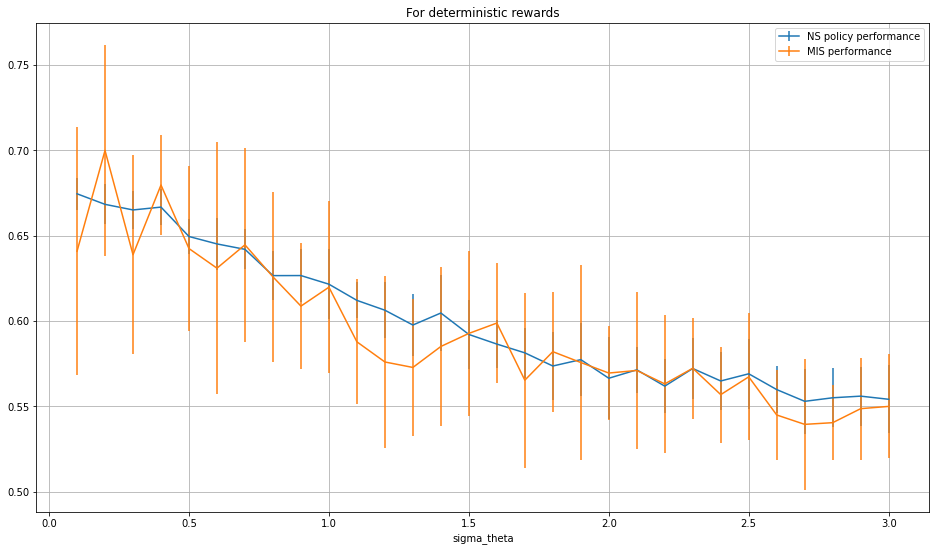

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_sigma_theta'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_sigma_theta'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_sigma_theta'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('sigma_theta')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of $A_\theta$ (with context)
I specify *with context* becaue if we remove it, the performance is max only for $A_\theta \rightarrow \infty$

In [35]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 5, 
    'A_theta': 1, 
    'A_r': 5, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}

est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 15,
    'range_A_theta': np.linspace(0.1,10,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for A_theta in tqdm(est_args['range_A_theta']):
    args['A_theta'] = A_theta
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


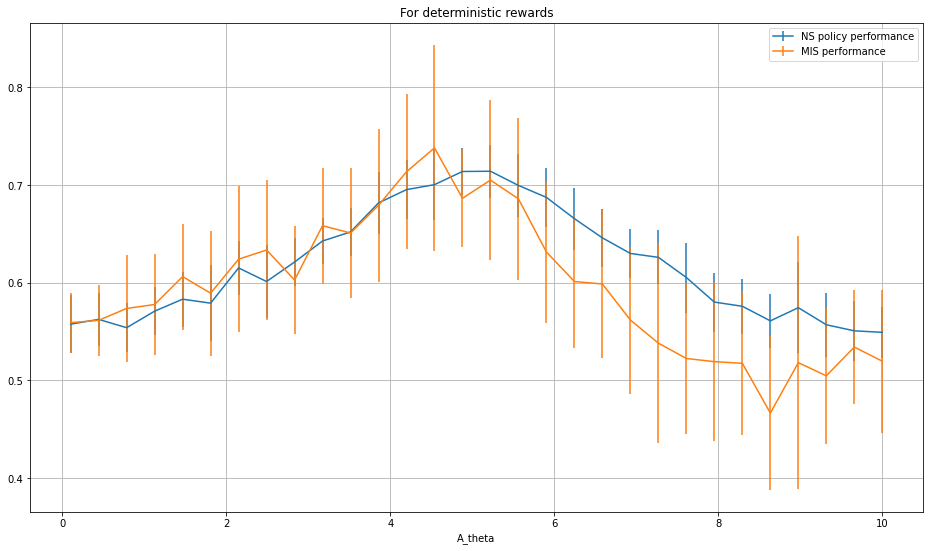

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_A_theta'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_A_theta'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_A_theta'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('A_theta')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of $\psi_\theta$

In [37]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 2, 
    'A_theta': 2, 
    'A_r': 2, 
    'psi_x': np.pi, 
    'psi_theta': 0, 
    'psi_r': np.pi, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}



est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 20,
    'range_psi': np.linspace(0,2*np.pi,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for psi in tqdm(est_args['range_psi']):
    args['psi_theta'] = psi
    #args['psi_r'] = psi
    #args['psi_x'] = psi
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)




100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


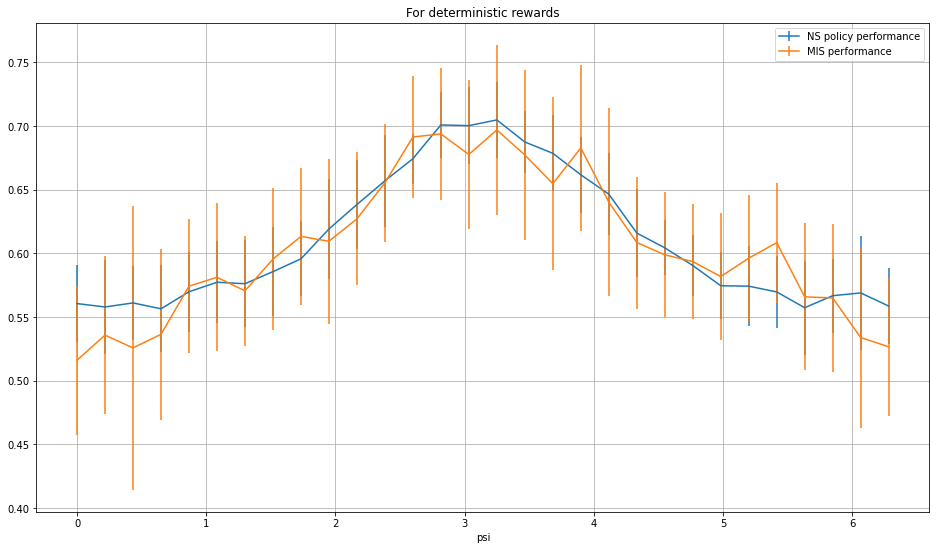

In [38]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_psi'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_psi'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_psi'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')

ax.grid()
ax.set_xlabel('psi')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of $\phi_\theta$

In [115]:
args = {
    'n_steps': 200, 
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'A_x': 0, 
    'A_theta': 1, 
    'A_r': 1, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}



est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 20,
    'range_phi': np.linspace(0.001,0.2,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for phi in tqdm(est_args['range_phi']):
    args['phi_theta'] = phi
    #args['phi_r'] = phi
    #args['phi_x'] = phi
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


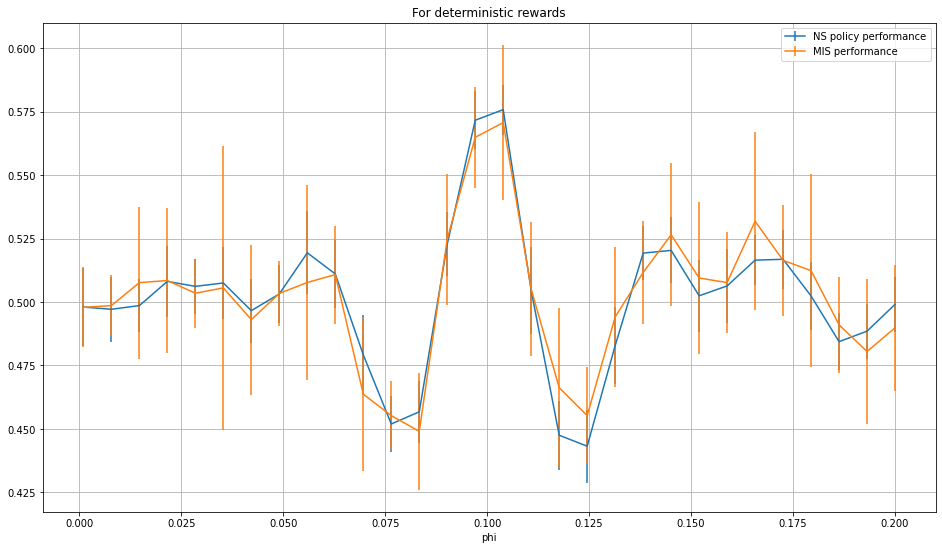

In [116]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_phi'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_phi'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
ax.grid()
ax.set_xlabel('phi')
ax.set_title('For deterministic rewards')
ax.legend()

phi seems to be the hardest parameter to learn, since the correct frequency (i.e. max performance) is inside two local minima of performance. Moreover, the gradient depends on t.

# OPTIMIZATION TESTS
## Optimize for a fixed t
Let's start by optimizing the simplest case, the one without context. Start by collecting alpha rewards and then optimizing the hyperpolicy keeping fixed the current t

In [9]:
### 'args' are used just to collect contexts using 'play()'
args = {
    'n_steps': 200, 
    
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'sigma_r': 1, 
    
    'A_x': 0, 
    'A_theta': 3, 
    'A_r': 3, 
    
    'phi_x': 0, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    
    'mean_reward': True,
}

contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)


NameError: name 'play' is not defined

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


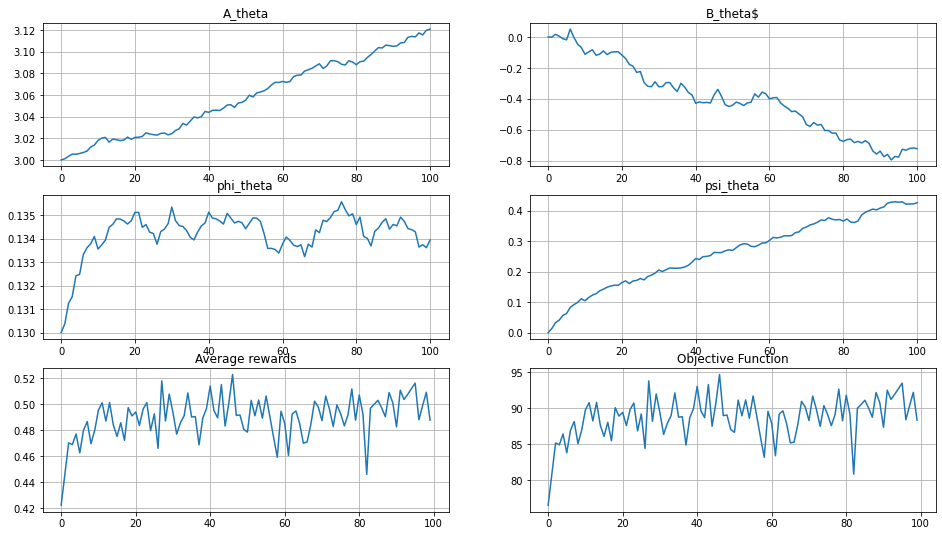

In [119]:
### Parameters of the hyperpolicy that will be optimized
optim_params = {
    'A_theta': 3,
    'phi_theta': 0.13,
    'psi_theta': 0,
    'B_theta': 0,
    'sigma_theta': 1,
    
    'learning_rate': [1e-3,1e-2,5*1e-6,1e-3],
    'lamb_J_1': 1,
    'lamb_J_2': 0,
    'lamb_v': 0,
    
    'n_steps': 200,
    'alpha': 180,
    'n_steps_optim': 100,
    'replicas': 5,
}

nu = Hyperpolicy(Policy, A=optim_params['A_theta'], B=optim_params['B_theta'], phi=optim_params['phi_theta'], 
                 psi=optim_params['psi_theta'], sigma_theta=optim_params['sigma_theta']) 
env = ContextualBandit(mean_reward=args['mean_reward'], A_x=args['A_x'], psi_x=args['psi_x'], phi_x=args['phi_x'],
                       A_r=args['A_r'], psi_r=args['psi_r'], phi_r=args['phi_r'], sigma_x=args['sigma_x']) 

t = len(contexts)

### Optimize params to perform better at current t
rewards_opt = np.zeros((optim_params['n_steps_optim'],optim_params['alpha']))
obj_values = np.zeros(optim_params['n_steps_optim'])
param_opt = np.zeros((optim_params['n_steps_optim']+1,4))
param_opt[0] = nu.get_params()

for i in tqdm(range(optim_params['n_steps_optim'])):
    nu, rewards, thetas, actions = optimize(contexts[t-optim_params['alpha']:], nu, env, t, replicas=optim_params['replicas'],
                                            lamb_J_1=optim_params['lamb_J_1'], lamb_J_2=optim_params['lamb_J_2'], 
                                            lamb_v=optim_params['lamb_v'], lr=optim_params['learning_rate'],  R_inf=1, 
                                            alpha=optim_params['alpha'], beta=1)
    param_opt[i+1] = nu.get_params()
    rewards_opt[i] = rewards
    obj_values[i] = objective_estimate(lamb=optim_params['lamb_v'],rewards=rewards, 
                                       thetas=thetas, nu=nu, t=t, alpha=optim_params['alpha'])
    

### Plot results
plots_dict = {
    'A_theta': [param_opt[:,0]],
    'B_theta$': [param_opt[:,1]],
    'phi_theta': [param_opt[:,2]],
    'psi_theta': [param_opt[:,3]],
    'Average rewards': [rewards_opt.mean(axis=1)],
    'Objective Function': [obj_values]
}

plots(plots_dict, title='Optimization for a fixed t ($lr = [10^{-3},10^{-2},2*10^{-6},10^{-3}], ~n_{seeds}=5$)')

## Optimize performing an update at each step

100%|██████████| 550/550 [04:16<00:00,  2.15it/s] 


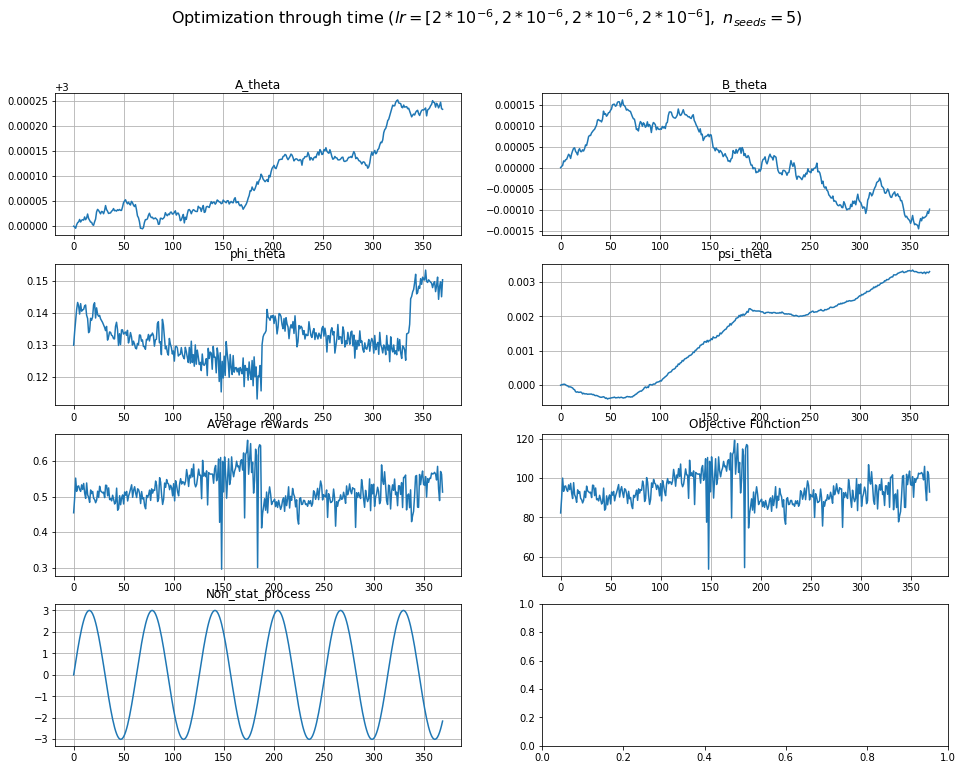

In [25]:
args = {    
    'sigma_theta': 1, 
    'A_theta': 3, 
    'B_theta': 0,
    'phi_theta': 0.13,
    'psi_theta': 0, 
    
    'sigma_x': 0, 
    'A_x': 0, 
    'phi_x': 0, 
    'psi_x': 0, 
    
    'sigma_r': 1, 
    'A_r': 3, 
    'phi_r': 0.1,
    'psi_r': 0, 
    
    'mean_reward': True,
    'n_steps': 550,
    'alpha': 180,
    'replicas': 5,
    
    'learning_rate': [2*1e-6,2*1e-6,2*1e-6,2*1e-6],
    'lamb_J_1': 1,
    'lamb_J_2': 0,
    'lamb_v': 0,
}


nu = Hyperpolicy(Policy, A=args['A_theta'], B=args['B_theta'], phi=args['phi_theta'], 
                 psi=args['psi_theta'], sigma_theta=args['sigma_theta']) 
env = ContextualBandit(mean_reward=args['mean_reward'], A_x=args['A_x'], psi_x=args['psi_x'], phi_x=args['phi_x'],
                       A_r=args['A_r'], psi_r=args['psi_r'], phi_r=args['phi_r'], sigma_x=args['sigma_x']) 

### Optimize params to perform better at current t
NS_process = np.zeros(args['n_steps'] - args['alpha'])
rewards_opt = np.zeros(args['n_steps'] - args['alpha'])
obj_values = np.zeros(args['n_steps'] - args['alpha'])
param_opt = np.zeros((args['n_steps'] - args['alpha'] + 1, 4))
param_opt[0] = nu.get_params()

contexts = np.zeros(args['n_steps'])
x_t = env.reset()

for t in tqdm(range(args['n_steps'])):
    
    # Store context
    contexts[t] = x_t
    
    # Perform an actual step
    policy = nu.sample_policy(t)
    action = policy.sample_action(x_t)
    x_t, r_t = env.step(action)
    
    # Perform an optimization step (if we have enough contexts)
    if t >= args['alpha']:
        nu, rewards, thetas, actions = optimize_avg_grad(contexts[t-args['alpha']:], nu, env, t, replicas=args['replicas'],
                                                lamb_J_1=args['lamb_J_1'], lamb_J_2=args['lamb_J_2'], 
                                                lamb_v=args['lamb_v'], lr=args['learning_rate'],  R_inf=1, 
                                                alpha=args['alpha'], beta=1)
        param_opt[t-args['alpha']+1] = nu.get_params()
        rewards_opt[t-args['alpha']] = rewards.mean()
        NS_process[t-args['alpha']] = env.non_stat_process_r(t-args['alpha'])
        obj_values[t-args['alpha']] = objective_estimate(lamb=args['lamb_v'], rewards=rewards, 
                                           thetas=thetas, nu=nu, t=t, alpha=args['alpha'])


### Plot results
plots_dict = {
    'A_theta': [param_opt[:,0]],
    'B_theta': [param_opt[:,1]],
    'phi_theta': [param_opt[:,2]],
    'psi_theta': [param_opt[:,3]],
    'Average rewards': [rewards_opt],
    'Objective Function': [obj_values],
    'Non_stat_process': [NS_process]
}

plots(plots_dict, title='Optimization through time ($lr = [2*10^{-6},2*10^{-6},2*10^{-6},2*10^{-6}], ~n_{seeds}=5$)')

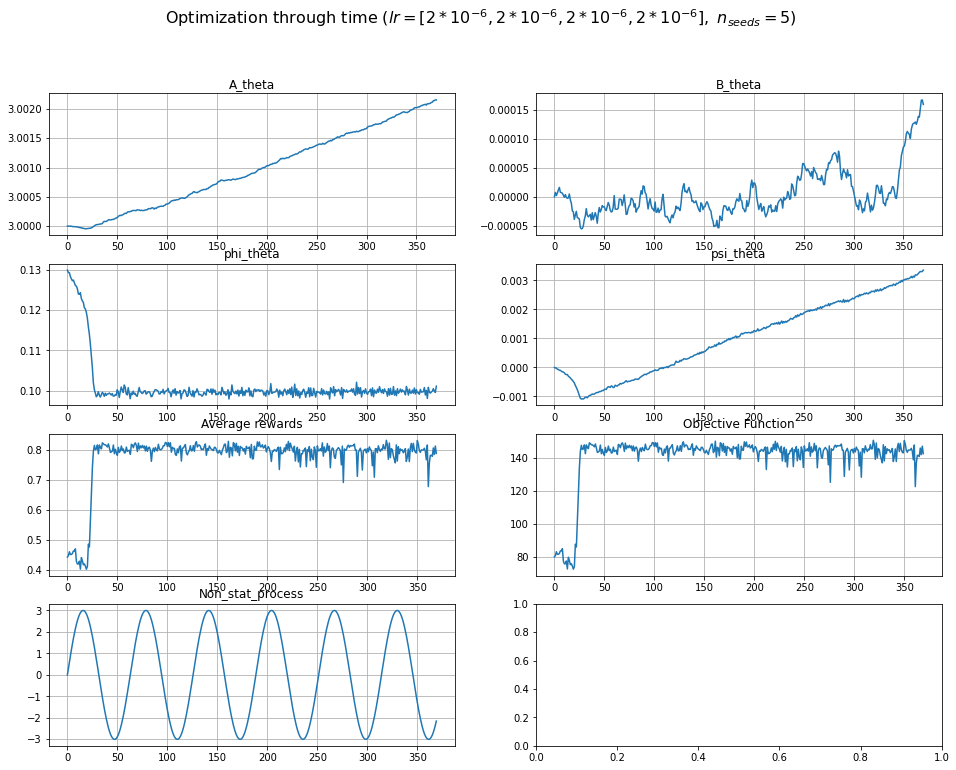

In [24]:
# Replot rewards
plots(plots_dict, title='Optimization through time ($lr = [2*10^{-6},2*10^{-6},2*10^{-6},2*10^{-6}], ~n_{seeds}=5$)')

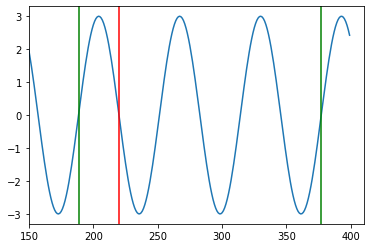

In [284]:
nu_test = Hyperpolicy(Policy, A=args['A_theta'], B=args['B_theta'], phi=args['phi_theta'], 
                      psi=0, sigma_theta=args['sigma_theta']) 
t=400
nu_test.theta_mean(t - ((nu_test.phi*t) % (2*np.pi)) / nu_test.phi)
nu_test.theta_mean((t-args['alpha']) - ((nu_test.phi*(t-args['alpha'])) % (2*np.pi)) / nu_test.phi)

plt.plot(nu_test.theta_mean(np.arange(t)))
plt.axvline((t-args['alpha']), c='red')
plt.axvline(t - ((nu_test.phi*t) % (2*np.pi)) / nu_test.phi, c='green')
plt.axvline((t-args['alpha']) - ((nu_test.phi*(t-args['alpha'])) % (2*np.pi)) / nu_test.phi, c='green')
plt.xlim(150,410)
plt.show() 

#plt.plot(nu.theta_mean(np.arange(t - (t-args['alpha']) + ((nu.phi*(t-args['alpha'])) % (2*np.pi)) / nu.phi))) 
# this is equal to having 180+(mod)/phi timesteps that influence the deriv of phi


# Run and optimize bandit with a single function (updated library)

In [96]:
### Import funtion that "does everything"
from optimize import intertwine_run_optimize, run_then_optimize

In [115]:
### Define all arguments for 'intertwine_run_optimize()'
all_args = {  
    
    # Parameters for each non-stationary process
    
    'sigma_x': 0,  'sigma_theta_behavioural': 0.1,   'sigma_theta_init': 0.1,    'sigma_r': 0.1, 
    'A_x': 0,      'A_theta_behavioural': 3,       'A_theta_init': 3,        'A_r': 3, 
    'psi_x': 0,    'psi_theta_behavioural': 0,     'psi_theta_init': 0,      'psi_r': 0, 
    'phi_x': 1,    'phi_theta_behavioural': 0.05,   'phi_theta_init': 0.1,   'phi_r': 0.05, 
    'B_x': 0,      'B_theta_behavioural': 0,       'B_theta_init': 0,        'B_r': 0, 
    
    # Run options
    'alpha': 300,
    'n_init_samples': 300,
    'n_optim_samples': 100,
    'optim_every': 1,
    'epochs_optim': 1,
    'seed': None,
    'save_folder': "results/no_context/optimization/many_t/test",
    
    # Optimization settings
    'grad_replicas': 1,
    'learning_rate': 1e-6,
    'lamb_J_1': 1,
    'lamb_J_2': 0,
    'lamb_v': 0,
    'mean_reward': True,
    'fix_phi': False,
    'use_modulo': False
}

### Run optimization with previous args
intertwine_run_optimize( **all_args )

100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


In [6]:
### Define all arguments for 'run_then_optimize_avg()'
all_args = {  
    
    # Parameters for each non-stationary process
    'sigma_x': 0,  'sigma_theta_behavioural': 0.1,   'sigma_theta_init': 0.1,
    'A_x': 1,      'A_theta_behavioural': 1,       'A_theta_init': 1,        'A_r': 1, 
    'psi_x': 0,    'psi_theta_behavioural': 0,     'psi_theta_init': 0,      'psi_r': 0, 
    'phi_x': 0,    'phi_theta_behavioural': 0.1,   'phi_theta_init': 0.09,   'phi_r': 0.1, 
    'B_x': 0,      'B_theta_behavioural': 0,       'B_theta_init': 0,        'B_r': 0, 
    
    # Run options
    'alpha': 180,
    'n_steps_sample': 180,
    'epochs_optim': 50,
    'seed': 5,
    'save_folder': "results/optimization/fixed_t/test_periodic_bandit",
    
    # Optimization settings
    'learning_rate': 2e-5,
    'lamb_J_1': 1,
    'lamb_J_2': 0,
    'lamb_v': 0,
    'mean_reward': True,
    'fix_phi': False,
    'use_modulo': False
}

run_then_optimize( **all_args )

thetas [ 0.09562619  0.02602749  0.16471693  0.24431245  0.24842471  0.41779463
  0.56177061  0.54772693  0.53297634  0.66696562  0.80830864  0.95074619
  0.9655522   0.94949096  0.85253071  1.0664123   0.99387942  0.97516977
  1.0898008   1.05211128  1.02380944  0.83433119  0.85638632  0.70757552
  0.8508272   0.78089732  0.81172084  0.67424508  0.54553619  0.71805569
  0.32442253  0.21076544  0.19756261  0.22322126  0.04657134 -0.05248109
 -0.21037735 -0.04001019 -0.33716189 -0.46820029 -0.45477345 -0.6021031
 -0.61917285 -0.53216695 -0.77470403 -0.79350412 -0.87746388 -0.90506317
 -0.84203017 -0.9014644  -1.01169162 -1.08560986 -1.01289722 -0.91508158
 -0.99086059 -0.98466889 -1.12760544 -0.81466357 -1.02302115 -0.95489293
 -0.81033523 -0.70912724 -0.64214286 -0.65185007 -0.53095573 -0.48046297
 -0.51744348 -0.27604076 -0.23184195 -0.03120022  0.00229388  0.20299182
  0.26516871  0.37283902  0.48879832  0.51936944  0.51184868  0.73795888
  0.57906959  0.7322307   0.87963246  0.81638

KeyboardInterrupt: 